In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Bidirectional
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt
import kerastuner as kt
from kerastuner import RandomSearch

# Load your data
data = pd.read_csv('Sri Lanka 3-Month Bond Yield Historical Data.csv')
data=data.iloc[::-1].reset_index(drop=True)

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[['Price']]  # Select the X3M column
data = data.dropna()
#original_data = data.copy()
#data=data[:round(len(data)*0.8)] 
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define the time step


C:\Users\Niroshan\AppData\Local\Temp\ipykernel_11204\496794919.py:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [2]:
time_step = 15
train_size = int(len(scaled_data) * 0.7)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - time_step:]

# Create the TimeseriesGenerator for training and testing data
train_generator = TimeseriesGenerator(train_data, train_data, length=time_step, batch_size=1)
test_generator = TimeseriesGenerator(test_data, test_data, length=time_step, batch_size=1)

In [3]:
def build_model(hp):
    model = Sequential()

    # Tune the number of LSTM units in the first LSTM layer
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50), 
                   activation='tanh', 
                   return_sequences=True, 
                   input_shape=(time_step, 1))))

    # Tune the dropout rate in the first LSTM layer
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))

    # Add a second LSTM layer (without return_sequences)
    model.add(Bidirectional(LSTM(units=hp.Int('units_2', min_value=50, max_value=200, step=50), activation='tanh')))
    
    # Dropout for the second LSTM layer
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(units=1, activation='relu'))

    # Tune the learning rate for the optimizer
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                  loss='mean_squared_error')
    return model

# Define the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  # Number of models to try
    executions_per_trial=3,  # Evaluate each model 3 times
    directory='tuning_dir',
    project_name='LSTM_Tuning'
)


Reloading Tuner from tuning_dir\LSTM_Tuning\tuner0.json


In [4]:
tuner.search(train_generator, epochs=10, validation_data=test_generator)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model with the optimal hyperparameters
history = model.fit(train_generator, epochs=50, validation_data=test_generator)

# Evaluate the model
test_loss = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")

c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
 12/174 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0327

c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


174/174 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - loss: 0.0112 - val_loss: 0.0252
Epoch 2/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0028 - val_loss: 0.0094
Epoch 3/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0016 - val_loss: 0.0113
Epoch 4/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0013 - val_loss: 0.0145
Epoch 5/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0017 - val_loss: 0.0062
Epoch 6/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0013 - val_loss: 0.0075
Epoch 7/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0018 - val_loss: 0.0050
Epoch 8/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0015 - val_loss: 0.0054
Epoch 9/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 8.0290e-04 - val_loss: 0.0063
Epoch 10/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0036 - val_loss: 0.0046
Epoch 11/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 8.1817e-04 - val_loss: 0.0118
Epoch 12/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 3s

In [5]:
print(f"The best number of units in the LSTM layer is {best_hps.get('units')}")
print(f"The best dropout rate is {best_hps.get('dropout')}")
#print(f"The best number of units in the dense layer is {best_hps.get('dense_units')}")
print(f"The best learning rate is {best_hps.get('learning_rate')}")

The best number of units in the LSTM layer is 50
The best dropout rate is 0.1
The best learning rate is 0.0009596496158057221


In [6]:
train_predict = model.predict(train_generator)
test_predict = model.predict(test_generator)

# Inverse transform the predictions to get actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Inverse transform the y_train and y_test to get actual values
y_train = scaler.inverse_transform(train_data[time_step:])
y_test = scaler.inverse_transform(test_data[time_step:])

174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━

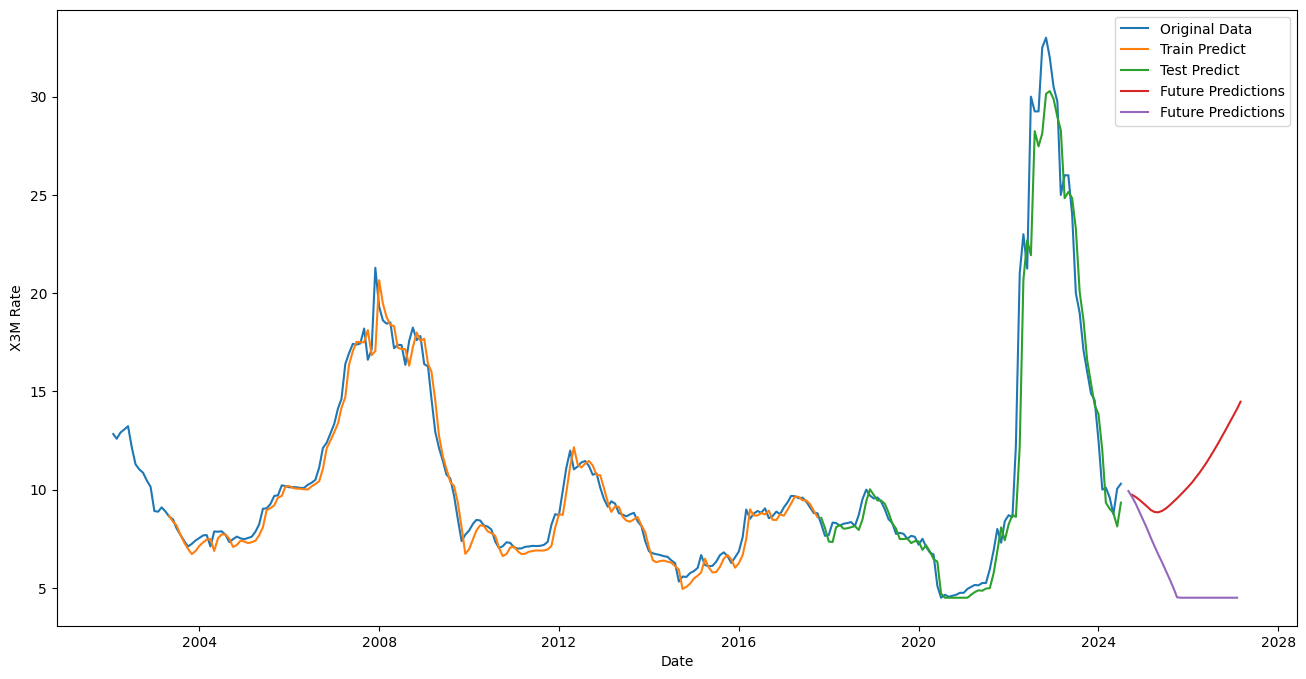

In [7]:
import os
def predict_future(model, data, time_step, future_steps):
    predictions = []
    last_sequence = data[-time_step:]
    
    for _ in range(future_steps):
        # Prepare the input data
        input_data = last_sequence.reshape((1, time_step, 1))
        
        # Predict the next value
        predicted_value = model.predict(input_data)
        
        # Store the predicted value
        predictions.append(predicted_value[0, 0])
        
        # Update the last_sequence
        last_sequence = np.append(last_sequence[1:], predicted_value, axis=0)
    
    return predictions

# Predict future interest rates for the next 12 months (or any desired future period)
future_steps = 30
future_predictions = predict_future(model, scaled_data, time_step, future_steps)

# Inverse transform the future predictions to get actual values
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))


# Prepare the data for plotting
train_predict_index = range(time_step, time_step + len(train_predict))
test_predict_index = range(len(train_predict) + (time_step * 2) + 1, len(scaled_data) - 1)
future_dates = pd.date_range(start=data.index[-1], periods=future_steps + 1, freq='M')[1:]
future_data = pd.DataFrame(future_predictions, index=future_dates, columns=['Future Predictions'])

interest_rate_type = '3-month'  # Change this label for different interest rate types
future_data.columns = [interest_rate_type]

# Rename the index to 'Date'
future_data.index.name = 'Date'

# Filepath of the CSV file
csv_file = 'future_predictions.csv'

# Check if the file exists, and if it does, append; otherwise, create it
if os.path.exists(csv_file):
    existing_data = pd.read_csv(csv_file, index_col=0, parse_dates=True)
    future_data = existing_data.join(future_data, how='outer')
    future_data.to_csv(csv_file)
else:
    future_data.to_csv(csv_file, mode='w')


# Plot the results
plt.figure(figsize=(16, 8))
plt.plot(data.index,data, label='Original Data')
plt.plot(data.index[train_predict_index], train_predict, label='Train Predict')
plt.plot(data.index[-len(test_predict):], test_predict, label='Test Predict')
plt.plot(future_data.index, future_data, label='Future Predictions')
plt.xlabel('Date')
plt.ylabel('X3M Rate')
plt.legend()
plt.show()

In [8]:
model.save('3_month.h5')